# Stock Prediction Using RNN's Long short-term memory

I will use <a href = "https://pydata.github.io/pandas-datareader/remote_data.html"> pandas_datareader </a> to read stock price from the populer websites because it can be inserted API keys.

<h2> Steps </h2>

- Data Collection
- Data Preprocessing (Split Train Test)
- Model Creation
- Testing
- Predict future 30 days and plot the output

### Data Collection

In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [3]:
df = web.DataReader('BTC-USD', 'yahoo', start='2019-2-2', end='2022-2-2')

In [4]:
df = df.reset_index()

In [5]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-02-01,3501.954102,3431.591553,3460.547119,3487.945312,5422926707,3487.945312
1,2019-02-02,3523.287354,3467.574707,3484.625977,3521.060791,5071623601,3521.060791
2,2019-02-03,3521.388184,3447.924316,3516.139648,3464.013428,5043937584,3464.013428
3,2019-02-04,3476.223877,3442.586914,3467.211670,3459.154053,5332718886,3459.154053
4,2019-02-05,3478.148193,3451.937012,3454.950928,3466.357422,5227549545,3466.357422
...,...,...,...,...,...,...,...
1093,2022-01-29,38576.261719,37406.472656,37780.714844,38138.179688,17194183075,38138.179688
1094,2022-01-30,38266.339844,37437.710938,38151.917969,37917.601562,14643548444,37917.601562
1095,2022-01-31,38647.261719,36733.574219,37920.281250,38483.125000,20734730465,38483.125000
1096,2022-02-01,39115.132812,38113.664062,38481.765625,38743.273438,20288500328,38743.273438


In [6]:
df1 = df['Close']
df1

0        3487.945312
1        3521.060791
2        3464.013428
3        3459.154053
4        3466.357422
            ...     
1093    38138.179688
1094    37917.601562
1095    38483.125000
1096    38743.273438
1097    37285.761719
Name: Close, Length: 1098, dtype: float64

In [7]:
df1.shape

(1098,)

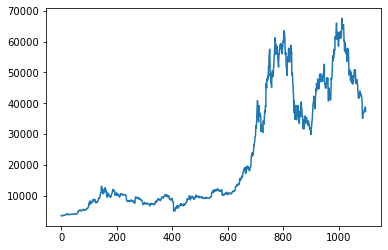

In [8]:
plt.plot(df1)

<h3> Data Preprocessing </h3>
</br>
<b> Scaling </b>
</br>
<code> LSTM is very sensitive to scale. So, I use MinMaxScaler(). </code>

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
# df1 is a dataframe from pandas. So, I convert dataframe to numpy array to handle later
# reshape(-1, 1) means 1 colum vector
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1.shape

(1098, 1)

In [11]:
#how converted array look like
# df1

<b> Train Test Split </b>

In [12]:
training_size = int(len(df1)*0.8)
test_size = len(df1) - training_size

train_data, test_data = df1[0:training_size], df1[training_size: len(df1)]

In [13]:
train_data.shape, test_data.shape

((878, 1), (220, 1))

In [14]:
def create_dataset(dataset, time_step = 1):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i: (i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)    

In [15]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape), print(X_test.shape), print(y_test.shape)

(777, 100)
(777,)
(119, 100)
(119,)


(None, None, None, None)

I reshape tensorshaped array like [samples, timesteps, features] which is required for LSTM

In [17]:
#  [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
X_train.shape

(777, 100, 1)

In [19]:
X_test.shape

(119, 100, 1)

### Model Creation

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model = Sequential()
model.add(LSTM(80, return_sequences = True, input_shape = (100, 1)))
model.add(LSTM(80, return_sequences = True))
model.add(LSTM(80))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 80)           26240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 80)           51520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 129,361
Trainable params: 129,361
Non-trainable params: 0
_________________________________________________________________


In [23]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs= {}):
        if(logs.get("val_loss") < 0.0009):
            print("\n loss is low. so stopped training")
            self.model.stop_training=True

In [24]:
callbacks = MyCallBack()

In [25]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1, callbacks = [callbacks])

Epoch 1/100
13/13 [==============================] - 3s 217ms/step - loss: 0.0248 - val_loss: 0.0103
Epoch 2/100
13/13 [==============================] - 2s 161ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 3/100
13/13 [==============================] - 2s 164ms/step - loss: 0.0027 - val_loss: 0.0076
Epoch 4/100
13/13 [==============================] - 3s 202ms/step - loss: 0.0024 - val_loss: 0.0068
Epoch 5/100
13/13 [==============================] - 3s 194ms/step - loss: 0.0023 - val_loss: 0.0081
Epoch 6/100
13/13 [==============================] - 2s 189ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 7/100
13/13 [==============================] - 3s 196ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 8/100
13/13 [==============================] - 3s 200ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 9/100
13/13 [==============================] - 2s 186ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 10/100
13/13 [==============================] - 2s 177ms/step - loss: 0.0018 - val_lo

In [26]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [27]:
# Transform original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

### Testing

In [28]:
# Calculate Root Mean Squared Error performance matrix
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

24545.77259953223

In [29]:
math.sqrt(mean_squared_error(y_test, test_predict))

52245.73900413695

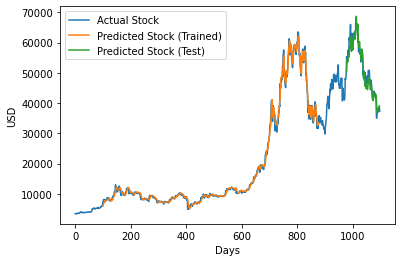

In [30]:
### Plotting

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(['Actual Stock', 'Predicted Stock (Trained)', 'Predicted Stock (Test)'])
plt.show()

### Predict Future 30 days' stock value

In [31]:
len(test_data)

220

In [32]:
x_input = test_data[120:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:
x_input

array([[0.88774611, 0.85842581, 0.89177221, 0.91679783, 0.9115127 ,
        0.90263163, 0.89772959, 0.93235773, 0.92836262, 0.90470859,
        0.89961948, 0.90588131, 0.93392528, 1.        , 0.99072737,
        0.95992358, 0.95921809, 0.9468439 , 0.9517309 , 0.96727326,
        0.93752342, 0.88458957, 0.88781186, 0.83442217, 0.85277171,
        0.87735769, 0.86229211, 0.82424803, 0.84419252, 0.82410991,
        0.83960461, 0.78186631, 0.80127356, 0.83919595, 0.84789366,
        0.83540849, 0.83890563, 0.82718609, 0.78231015, 0.71377775,
        0.71639816, 0.73531397, 0.73714451, 0.73410107, 0.68995595,
        0.68327317, 0.71629936, 0.72776668, 0.67539028, 0.67344462,
        0.70904045, 0.68985161, 0.66704747, 0.67712476, 0.67491551,
        0.67761566, 0.70966211, 0.70486058, 0.73846064, 0.73904749,
        0.73293323, 0.73884989, 0.73621463, 0.68865832, 0.67082769,
        0.68225739, 0.66867292, 0.69018491, 0.68486142, 0.67103661,
        0.66230097, 0.62601195, 0.61965242, 0.59

In [34]:
temp_input = x_input.tolist()
temp_input = temp_input[0]
temp_input

[0.8877461133623467,
 0.8584258116665233,
 0.8917722064462994,
 0.9167978302830643,
 0.9115127004088263,
 0.9026316270473939,
 0.8977295896458987,
 0.9323577279523867,
 0.9283626207366409,
 0.9047085933567912,
 0.899619484102644,
 0.9058813080230738,
 0.9339252841534237,
 0.9999999999999999,
 0.9907273724061377,
 0.9599235842224282,
 0.959218092618008,
 0.9468438952809756,
 0.9517308963181347,
 0.9672732617083931,
 0.9375234191755011,
 0.8845895726191945,
 0.8878118594088368,
 0.8344221735968655,
 0.8527717125443441,
 0.877357690133191,
 0.8622921053319237,
 0.8242480337784924,
 0.8441925231130455,
 0.8241099062048942,
 0.8396046057114473,
 0.7818663059319081,
 0.8012735648402806,
 0.8391959453317362,
 0.847893660274624,
 0.8354084860461549,
 0.8389056278357072,
 0.827186090669003,
 0.7823101526216852,
 0.7137777521557588,
 0.716398158240172,
 0.7353139654510309,
 0.7371445058380283,
 0.7341010726452266,
 0.6899559506054214,
 0.6832731693595481,
 0.7162993565425299,
 0.7277666845697818

### preidction for next 30 days

In [35]:
from numpy import array

lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input)> 100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose = 0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose = 0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i= i+1
        
print(lst_output)        

[0.5551905]
101
1 day input [0.85842581 0.89177221 0.91679783 0.9115127  0.90263163 0.89772959
 0.93235773 0.92836262 0.90470859 0.89961948 0.90588131 0.93392528
 1.         0.99072737 0.95992358 0.95921809 0.9468439  0.9517309
 0.96727326 0.93752342 0.88458957 0.88781186 0.83442217 0.85277171
 0.87735769 0.86229211 0.82424803 0.84419252 0.82410991 0.83960461
 0.78186631 0.80127356 0.83919595 0.84789366 0.83540849 0.83890563
 0.82718609 0.78231015 0.71377775 0.71639816 0.73531397 0.73714451
 0.73410107 0.68995595 0.68327317 0.71629936 0.72776668 0.67539028
 0.67344462 0.70904045 0.68985161 0.66704747 0.67712476 0.67491551
 0.67761566 0.70966211 0.70486058 0.73846064 0.73904749 0.73293323
 0.73884989 0.73621463 0.68865832 0.67082769 0.68225739 0.66867292
 0.69018491 0.68486142 0.67103661 0.66230097 0.62601195 0.61965242
 0.59467045 0.59741389 0.60018259 0.59877471 0.61302796 0.63193549
 0.61077939 0.61869819 0.61990908 0.61891917 0.60546485 0.60741416
 0.59757575 0.58099551 0.51518165 0

In [36]:
day_new = np.arange(1, 101) #100 days
day_pred = np.arange(101, 131) # 30 days

In [37]:
import matplotlib.pyplot as plt

In [38]:
len(df1)

1098

In [39]:
new_df = df1.tolist()
new_df.extend(lst_output)

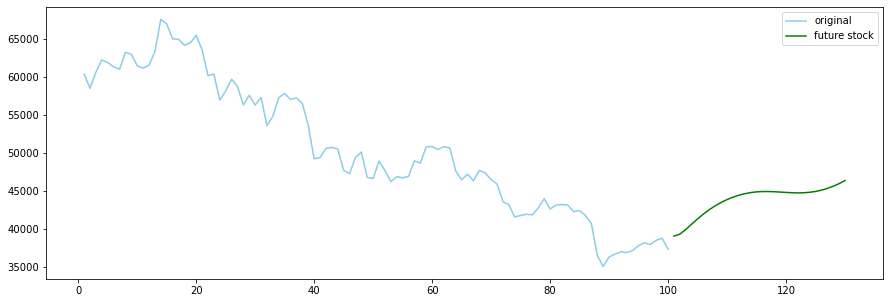

In [43]:
plt.figure(figsize=(15,5))
plt.plot(day_new, scaler.inverse_transform(df1[998:]), color = 'skyblue')
plt.plot(day_pred, scaler.inverse_transform(lst_output), color = 'green')
plt.legend(['original','future stock'])

<b> overview the plot </b>

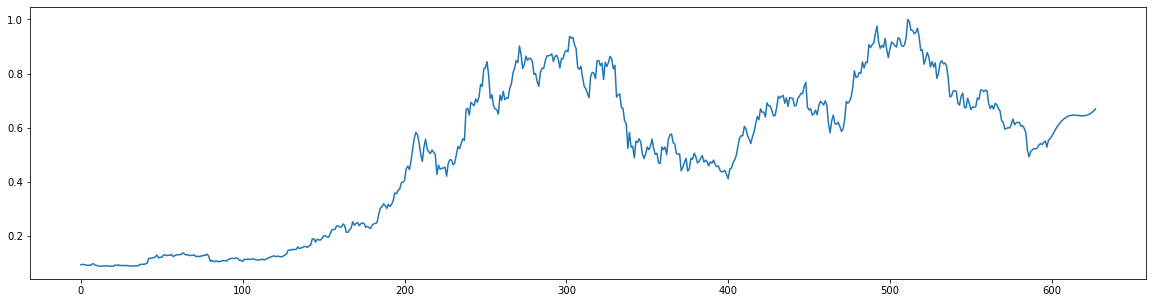

In [42]:
new_df = df1.tolist()
new_df.extend(lst_output)
plt.figure(figsize=(20,5))
plt.plot(new_df[500:])
